# MDPy: Biblioteca geral para MDPs em python

Este código faz uso da biblioteca MDPy (https://github.com/MeepMoop/MDPy) para criar e resolver MDPs finitos simples de forma interativa.

## Imports

In [5]:
import numpy as np
import copy
import scipy.optimize

## Classe MDP

Implementação da classe MDP conforme definida em: https://github.com/MeepMoop/MDPy/blob/master/MDPy.py

In [6]:
class MDP(object):
  def __init__(self):
    self._mdp = []

  # add a number of states to the MDP
  def add_states(self, num_states):
    for s in range(num_states):
      self._mdp.append([])

  # add a number of actions to a state in the MDP
  def add_actions(self, state, num_actions):
    for a in range(num_actions):
      self._mdp[state].append([])

  # add a transition tuple (s', r, P) to a state-action pair in the MDP
  def add_transition(self, state, action, transition):
    self._mdp[state][action].append(transition)

  # remove a state from the MDP
  def remove_state(self, index):
    self._mdp.pop(index)

  # remove an action from a state in the MDP
  def remove_action(self, state, index):
    self._mdp[state].pop(index)

  # remove a transtion from a state-action pair in the MDP
  def remove_transition(self, state, action, index):
    self._mdp[state][action].pop(index)

  # clear all states from the MDP
  def clear_states(self):
    self._mdp = []

  # clear all actions from a state in the MDP
  def clear_actions(self, state):
    self._mdp[state] = []

  # clear all transitions from a state-action pair in the MDP
  def clear_transitions(self, state, action):
    self._mdp[state][action] = []

  # returns the number of states in the MDP
  def num_states(self):
    return len(self._mdp)

  # returns the number of actions in a state in the MDP
  def num_actions(self, state):
    return len(self._mdp[state])

  # returns the number of transitions in a state-action pair in the MDP
  def num_transitions(self, state, action):
    return len(self._mdp[state][action])

  # returns transition probabilities of a state-action pair in the MDP
  def get_probabilities(self, state, action):
    return [self._mdp[state][action][tr][2] for tr in range(self.num_transitions(state, action))]

  # return a tuple with a next state and reward sampled from the transitions of a state-action pair
  def do_action(self, state, action):
    tr = np.random.choice(self.num_transitions(state, action), p=self.get_probabilities(state, action))
    return self._mdp[state][action][tr][:-1]

  # returns state-values V[s] under a policy P(Q[s], s) for an MDP
  def value_policy(self, policy, gamma, tolerance=1e-6, V0=None):
    V = [0.0 for s in range(self.num_states())] if V0 == None else V0
    dv = tolerance
    while dv >= tolerance:
      dv = 0.0
      Vold = copy.deepcopy(V)
      for s in range(self.num_states()):
        if self.num_actions(s) == 0:
          continue
        Q = np.zeros(self.num_actions(s))
        for a in range(self.num_actions(s)):
          for tr in self._mdp[s][a]:
            Q[a] += tr[2] * (tr[1] + gamma * Vold[tr[0]])
        V[s] = np.dot(policy(Q, s), Q)
        if abs(V[s] - Vold[s]) > dv:
          dv = abs(V[s] - Vold[s])
    return V

  # returns state-values V[s] under a greedy policy for the MDP
  def value_iteration(self, gamma, tolerance=1e-6, V0=None):
    pi = lambda Q, s: [1 if i == np.argmax(Q) else 0 for i in range(len(Q))]
    return self.value_policy(pi, gamma, tolerance, V0)

  # returns state-values V[s] under an epsilon-greedy policy for the MDP
  def value_eps_greedy(self, epsilon, gamma, tolerance=1e-6, V0=None):
    pi = lambda Q, s: [1 - epsilon + epsilon / len(Q) if i == np.argmax(Q) else epsilon / len(Q) for i in range(len(Q))]
    return self.value_policy(pi, gamma, tolerance, V0)

  # returns state-values V[s] under an equiprobable random policy for the MDP
  def value_equiprobable(self, gamma, tolerance=1e-6, V0=None):
    pi = lambda Q, s: [1 / len(Q) for i in range(len(Q))]
    return self.value_policy(pi, gamma, tolerance, V0)

  # returns state-values V[s] under a tempered-softmax policy for the MDP
  def value_softmax(self, tau, gamma, tolerance=1e-6, V0=None):
    pi = lambda Q, s: np.exp((Q - np.max(Q)) / tau) / np.exp((Q - np.max(Q)) / tau).sum() if len(Q) > 0 else []
    return self.value_policy(pi, gamma, tolerance, V0)

  # returns state-values V[s] under a mellowmax policy for the MDP
  def value_mellowmax(self, omega, gamma, tolerance=1e-6, V0=None, a=-1000, b=1000):
    def pi(Q, s):
      if len(Q) == 0: return []
      mm = np.max(Q) + np.log(np.exp(omega * (Q - np.max(Q))).mean()) / omega
      beta = scipy.optimize.brentq(lambda beta: np.sum(np.exp(beta * (Q - mm) - np.max(beta * (Q - mm))) * (Q - mm)), a=a, b=b)
      return np.exp(beta * (Q - np.max(Q))) / np.exp(beta * (Q - np.max(Q))).sum()
    return self.value_policy(pi, gamma, tolerance, V0)

  # returns action-values Q[s][a] under a policy P(Q[s], s) for an MDP
  def Q_policy(self, policy, gamma, tolerance=1e-6, Q0=None):
    Q = [[0.0 for a in range(self.num_actions(s))] for s in range(self.num_states())] if Q0 == None else Q0
    dv = tolerance
    while dv >= tolerance:
      dv = 0.0
      Qold = copy.deepcopy(Q)
      for s in range(self.num_states()):
        for a in range(self.num_actions(s)):
          Q[s][a] = 0.0
          for tr in self._mdp[s][a]:
            Q[s][a] += tr[2] * (tr[1] + gamma * np.dot(policy(Qold[tr[0]], tr[0]), Qold[tr[0]]))
          if abs(Q[s][a] - Qold[s][a]) > dv:
            dv = abs(Q[s][a] - Qold[s][a])
    return Q

  # returns action-values Q[s][a] under a greedy policy for the MDP
  def Q_iteration(self, gamma, tolerance=1e-6, Q0=None):
    pi = lambda Q, s: [1 if i == np.argmax(Q) else 0 for i in range(len(Q))]
    return self.Q_policy(pi, gamma, tolerance, Q0)

  # returns action-values Q[s][a] under an epsilon-greedy policy for the MDP
  def Q_eps_greedy(self, epsilon, gamma, tolerance=1e-6, Q0=None):
    pi = lambda Q, s: [1 - epsilon + epsilon / len(Q) if i == np.argmax(Q) else epsilon / len(Q) for i in range(len(Q))]
    return self.Q_policy(pi, gamma, tolerance, Q0)

  # returns action-values Q[s][a] under an equiprobable random policy for the MDP
  def Q_equiprobable(self, gamma, tolerance=1e-6, Q0=None):
    pi = lambda Q, s: [1 / len(Q) for i in range(len(Q))]
    return self.Q_policy(pi, gamma, tolerance, Q0)

  # returns action-values Q[s][a] under a tempered-softmax policy for the MDP
  def Q_softmax(self, tau, gamma, tolerance=1e-6, Q0=None):
    pi = lambda Q, s: np.exp((Q - np.max(Q)) / tau) / np.exp((Q - np.max(Q)) / tau).sum() if len(Q) > 0 else []
    return self.Q_policy(pi, gamma, tolerance, Q0)

  # returns action-values Q[s][a] under a mellowmax policy for the MDP
  def Q_mellowmax(self, omega, gamma, tolerance=1e-6, Q0=None, a=-1000, b=1000):
    def pi(Q, s):
      if len(Q) == 0: return []
      mm = np.max(Q) + np.log(np.exp(omega * (Q - np.max(Q))).mean()) / omega
      beta = scipy.optimize.brentq(lambda beta: np.sum(np.exp(beta * (Q - mm) - np.max(beta * (Q - mm))) * (Q - mm)), a=a, b=b)
      return np.exp(beta * (Q - np.max(Q))) / np.exp(beta * (Q - np.max(Q))).sum()
    return self.Q_policy(pi, gamma, tolerance, Q0)

  # checks if a state is terminal
  def is_terminal(self, state):
    return self.num_actions(state) == 0

## Teste: MDP simples

Vamos criar um MDP simples a partir da classe definida acima.
Seja o Processo de Decisão de Markov com dois estados representado abaixo:

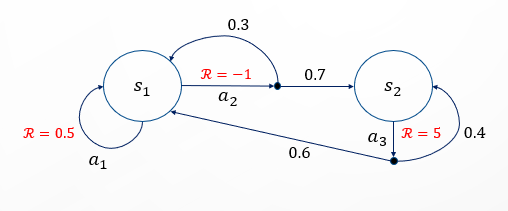

In [8]:
# create an MDP
mdp = MDP()

# add 2 states
mdp.add_states(2)

# add 2 actions to the first state and 1 action to the second state
mdp.add_actions(0, 2)
mdp.add_actions(1, 1)

# add transitions (s', r, P) for each state-action pair
mdp.add_transition(0, 0, (0, 0.5, 1.0))
mdp.add_transition(0, 1, (0, -1.0, 0.3))
mdp.add_transition(0, 1, (1, -1.0, 0.7))
mdp.add_transition(1, 0, (0, 5.0, 0.6))
mdp.add_transition(1, 0, (1, 5.0, 0.4))

# output optimal state-value and action-value functions with discount rate 0.9
print ('V*[s] = '+ str(mdp.value_iteration(0.9)))
print ('Q*[s][a] = ' + str(mdp.Q_iteration(0.9)))

V*[s] = [19.763771071539075, 24.488180520357975]
Q*[s][a] = [[18.28739311878317, 19.763771071539075], [24.488180520357975]]


## Teste: MDP exemplo Aula 2

Vamos criar o MDP exemplo da aula 2 e comparar a solução obtida pelo método de Value Iteration com a solução analítica da equação de Bellman implementada em A2_ExemploAula.ipynb.

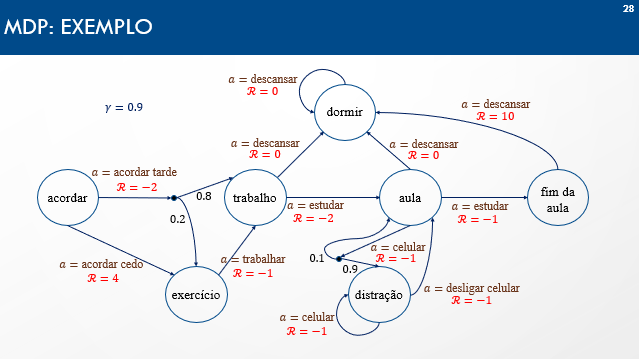

In [11]:
# create an MDP
#---------------
mdp = MDP()

# add states ('acordar', 'exercício', 'trabalho', 'aula', 'distração', 'fim da aula', 'dormir')
#-----------------------------------------------------------------------------------------------
mdp.add_states(7)

# add action ('acordar_cedo', 'acordar_tarde', 'trabalhar', 'estudar', 'celular', 'desligar_celular', 'descansar')
#------------------------------------------------------------------------------------------------------------------
mdp.add_actions(0, 2) # s = 'acordar',          a = {'acordar_cedo', 'acordar_tarde'}
mdp.add_actions(1, 1) # s = 'exercício'         a = {'trabalhar'}
mdp.add_actions(2, 2) # s = 'trabalho',         a = {'estudar', 'descansar'}
mdp.add_actions(3, 3) # s = 'aula',             a = {'celular', 'estudar', 'descansar'}
mdp.add_actions(4, 2) # s = 'distração',        a = {'celular', 'desligar_celular'}
mdp.add_actions(5, 1) # s = 'fim da aula',      a = {'descansar'}
mdp.add_actions(6, 1) # s = 'dormir',           a = {'descansar'}

# add transitions (s', r, P) for each state-action pair
#--------------------------------------------------------
mdp.add_transition(0, 0, (1, 4.0, 1.0)) # s = 'acordar', a = 'acordar_cedo'
mdp.add_transition(0, 1, (2, -2.0, 0.8)) # s = 'acordar', a = 'acordar_tarde', p=0.8
mdp.add_transition(0, 1, (1, -2.0, 0.2)) # s = 'acordar', a = 'acordar_tarde', p=0.2

mdp.add_transition(1, 0, (2, -1.0, 1.0)) # s = 'exercício', a = 'trabalhar'

mdp.add_transition(2, 0, (3, -2.0, 1.0)) # s = 'trabalho', a = 'estudar'
mdp.add_transition(2, 1, (6, 0.0, 1.0)) # s = 'trabalho', a = 'descansar'

mdp.add_transition(3, 0, (4, -1.0, 0.9)) # s = 'aula', a = 'celular', p=0.9
mdp.add_transition(3, 0, (3, -1.0, 0.1)) # s = 'aula', a = 'celular', p=0.1
mdp.add_transition(3, 1, (5, -1.0, 1.0)) # s = 'aula', a = 'estudar'
mdp.add_transition(3, 2, (6, 0.0, 1.0)) # s = 'aula', a = 'descansar'

mdp.add_transition(4, 0, (4, -1.0, 1.0)) # s = 'distração', a = 'celular'
mdp.add_transition(4, 1, (3, -1.0, 1.0)) # s = 'distração', a = 'desligar_celular'

mdp.add_transition(5, 0, (6, 10.0, 1.0)) # s = 'fim da aula', a = 'descansar'

mdp.add_transition(6, 0, (6, 0.0, 1.0)) # s = 'dormir', a = 'descansar'

# output optimal state-value and action-value functions with discount rate 0.9
V_opt = mdp.value_iteration(0.9)
Q_opt = mdp.Q_iteration(0.9)
print ('V*[s] = '+ str(V_opt))
print ('Q*[s][a] = ' + str(Q_opt))

print('')
print('V(acordar) = ' + str(V_opt[0]))
print('V(exercício) = ' + str(V_opt[1]))
print('V(trabalho) = ' + str(V_opt[2]))
print('V(aula) = ' + str(V_opt[3]))
print('V(distração) = ' + str(V_opt[4]))
print('V(fim da aula) = ' + str(V_opt[5]))
print('V(dormir) = ' + str(V_opt[6]))

print('')
print('Q(acordar, acordar_cedo) = ' + str(Q_opt[0][0]))
print('Q(acordar, acordar_tarde) = ' + str(Q_opt[0][1]))
print('Q(exercício, trabalhar) = ' + str(Q_opt[1][0]))
print('Q(trabalho, estudar) = ' + str(Q_opt[2][0]))
print('Q(trabalho, descansar) = ' + str(Q_opt[2][1]))
print('Q(aula, celular) = ' + str(Q_opt[3][0]))
print('Q(aula, estudar) = ' + str(Q_opt[3][1]))
print('Q(aula, descansar) = ' + str(Q_opt[3][2]))
print('Q(distração, celular) = ' + str(Q_opt[4][0]))
print('Q(distração, desligar_celular) = ' + str(Q_opt[4][1]))
print('Q(fim da aula, descansar) = ' + str(Q_opt[5][0]))
print('Q(dormir, descansar) = ' + str(Q_opt[6][0]))


V*[s] = [7.312000000000001, 3.6800000000000006, 5.2, 8.0, 6.2, 10.0, 0.0]
Q*[s][a] = [[7.312000000000001, 2.4064000000000005], [3.6800000000000006], [5.2, 0.0], [4.742, 8.0, 0.0], [4.58, 6.2], [10.0], [0.0]]

V(acordar) = 7.312000000000001
V(exercício) = 3.6800000000000006
V(trabalho) = 5.2
V(aula) = 8.0
V(distração) = 6.2
V(fim da aula) = 10.0
V(dormir) = 0.0

Q(acordar, acordar_cedo) = 7.312000000000001
Q(acordar, acordar_tarde) = 2.4064000000000005
Q(exercício, trabalhar) = 3.6800000000000006
Q(trabalho, estudar) = 5.2
Q(trabalho, descansar) = 0.0
Q(aula, celular) = 4.742
Q(aula, estudar) = 8.0
Q(aula, descansar) = 0.0
Q(distração, celular) = 4.58
Q(distração, desligar_celular) = 6.2
Q(fim da aula, descansar) = 10.0
Q(dormir, descansar) = 0.0


Percebemos que os valores são consistentes com os obtidos pela solução analítica da Equação de Bellman:
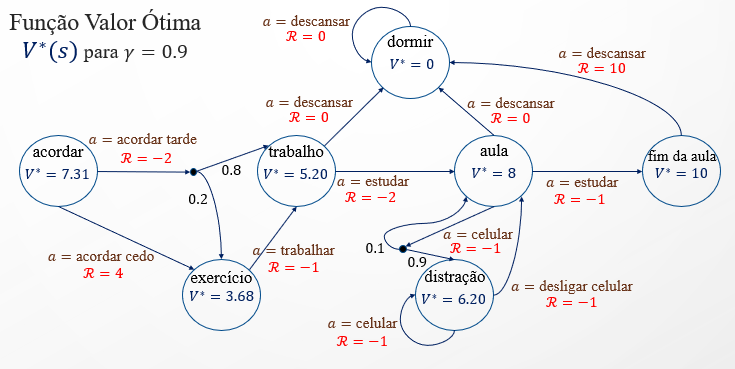